# z_analysis — Static Matching Analyses
Experiments included:
1. **Class separability** for AAP / AT / MHRP (SB/SW, Silhouette, DB-Index)
2. **AT overlays**: image + upsampled attention map (teacher vs student vs student_kd)
3. **AT linear probe** (train: train split features, eval: valid split) for 2 datasets

Assumes:
- Features were collected with `src/z_collect.py` and stored in HDF5 using config at `experiments/analysis/config.yaml`.
- HDF5 schema:
  - `/features/{model}/{style}/layer_{i}/(emb|class_id|sample_id)`
  - `/logits/{model}/(logits|margin)`
  - `/prototypes/{model}/{style}/layer_{i}/mu`


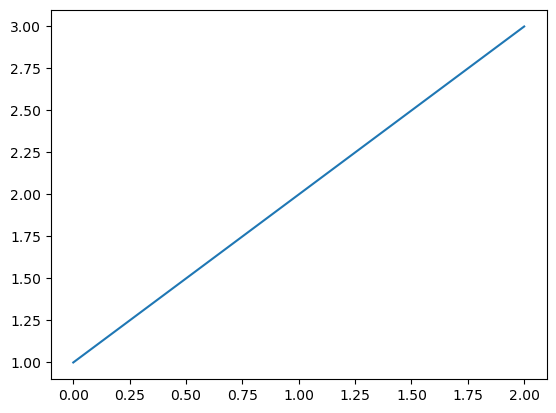

In [1]:
import matplotlib.pyplot as plt

plt.plot([1,2,3])
plt.show()

In [63]:
import os, sys, math, json, yaml, time, random
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

# Project root import
if os.path.exists("src"):
    sys.path.append(os.getcwd())
    sys.path.append("src")

CFG_PATH = r"experiments/analysis/config.yaml"
with open(CFG_PATH, "r") as f:
    CFG = yaml.safe_load(f)

H5_TPL = CFG.get("storage", {}).get("h5_path_tpl", "runs/z_store/{dataset}_{split}.h5")
DATASETS = CFG.get("data", {}).get("datasets", [])
SPLITS = CFG.get("data", {}).get("splits", ["train","valid"])

MODELS = ["teacher","student","student_kd","student_rkd"]
STYLES = []
if CFG.get("transforms", {}).get("aap", {}).get("enabled", True):
    STYLES.append("aap")
if CFG.get("transforms", {}).get("at", {}).get("enabled", True):
    STYLES.append("at")
if CFG.get("transforms", {}).get("mhrp", {}).get("enabled", True):
    STYLES.append("mhrp")

print("Config loaded. Datasets:", DATASETS, "Splits:", SPLITS, "Styles:", STYLES)


Config loaded. Datasets: ['cifar10', 'tiny_imagenet'] Splits: ['train', 'valid'] Styles: ['aap', 'at', 'mhrp']


In [58]:
def h5_path_for(dataset: str, split: str) -> str:
    return H5_TPL.format(dataset=dataset, split=split)

def read_features(h5_path: str, model: str, style: str, layer_idx: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (emb, class_id, sample_id) arrays."""
    with h5py.File(h5_path, "r") as h5:
        base = f"/features/{model}/{style}/layer_{layer_idx}"
        if base not in h5:
            # try head subgroup (e.g., /mean)
            if f"/features/{model}/{style}" in h5:
                g = h5[f"/features/{model}/{style}"].get(f"layer_{layer_idx}", None)
                if g is not None and "mean" in g:
                    base = f"{base}/mean"
                else:
                    raise KeyError(f"No features at {base}")
            else:
                raise KeyError(f"No features at {base}")
        g = h5[base]
        emb = g["emb"][:]
        cls = g["class_id"][:].reshape(-1)
        sid = g["sample_id"][:].reshape(-1)
    return emb, cls, sid

def list_layers(h5_path: str, model: str, style: str) -> List[int]:
    with h5py.File(h5_path, "r") as h5:
        base = f"/features/{model}/{style}"
        if base not in h5: return []
        ks = list(h5[base].keys())
        out = []
        for k in ks:
            if k.startswith("layer_"):
                try:
                    out.append(int(k.split("_")[-1]))
                except: pass
        return sorted(out)


## 1) Class separability metrics
We compute:
- **SB/SW** (between/within class scatter ratio)
- **Silhouette score** (implemented here w/o sklearn)
- **Davies–Bouldin index (DBI)**

All work on (N,D) embeddings + integer labels.


In [4]:
def separability_SB_SW(X: np.ndarray, y: np.ndarray) -> float:
    """Return SB/SW. Larger is better."""
    X = X.astype(np.float64)
    y = y.astype(int)
    classes = np.unique(y)
    mu = X.mean(axis=0, keepdims=True)
    SB = 0.0
    SW = 0.0
    for c in classes:
        Xc = X[y==c]
        if len(Xc)==0: 
            continue
        muc = Xc.mean(axis=0, keepdims=True)
        SB += len(Xc) * np.sum((muc - mu)**2)
        SW += np.sum((Xc - muc)**2)
    return (SB / (SW + 1e-12))

def silhouette_score_simple(X: np.ndarray, y: np.ndarray, sample_limit: int=1000) -> float:
    """Approx silhouette (cosine distance) on a subsample for speed."""
    N = X.shape[0]
    if N > sample_limit:
        idx = np.random.RandomState(0).choice(N, sample_limit, replace=False)
        X = X[idx]
        y = y[idx]
        N = sample_limit
    # normalize for cosine distance
    X = X.astype(np.float64)
    X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    # pairwise cosine distance
    S = 1.0 - X @ X.T  # (N,N)
    a = np.zeros(N)
    b = np.full(N, np.inf)
    for i in range(N):
        same = (y == y[i])
        other = ~same
        if np.sum(same) > 1:
            a[i] = np.sum(S[i, same]) / (np.sum(same)-1)
        else:
            a[i] = 0.0
        # nearest other-cluster mean distance
        for c in np.unique(y[other]):
            b[i] = min(b[i], np.mean(S[i, y==c]))
        if not np.isfinite(b[i]): b[i]=0.0
    s = (b - a) / (np.maximum(a, b) + 1e-12)
    return float(np.mean(s))

def davies_bouldin_index(X: np.ndarray, y: np.ndarray) -> float:
    """Lower is better."""
    X = X.astype(np.float64)
    y = y.astype(int)
    classes = np.unique(y)
    k = len(classes)
    if k <= 1: return np.nan
    centroids = []
    sigmas = []
    for c in classes:
        Xc = X[y==c]
        mu = Xc.mean(axis=0, keepdims=True)
        centroids.append(mu)
        # sigma: mean intra-cluster distance to centroid
        dist = np.linalg.norm(Xc - mu, axis=1)
        sigmas.append(dist.mean() if len(dist)>0 else 0.0)
    centroids = np.vstack(centroids)  # (k,D)
    sigmas = np.array(sigmas)         # (k,)
    # pairwise centroid distances
    M = np.linalg.norm(centroids[:,None,:] - centroids[None,:,:], axis=2) + 1e-12
    R = (sigmas[:,None] + sigmas[None,:]) / M
    np.fill_diagonal(R, -np.inf)
    D = np.max(R, axis=1)
    return float(np.mean(D))


In [69]:
# about 3 mins required

def compute_separability_for(h5_path: str, model: str, style: str, layer_idx: int) -> dict:
    X, y, sid = read_features(h5_path, model, style, layer_idx)
    # Already L2-normalized during collection; still safe.
    sb_sw = separability_SB_SW(X, y)
    sil = silhouette_score_simple(X, y, sample_limit=1000)
    dbi = davies_bouldin_index(X, y)
    return {"SB/SW": sb_sw, "Silhouette": sil, "DBI": dbi, "N": X.shape[0], "D": X.shape[1]}

if os.path.exists('z_sep_df.csv'):
    sep_df = pd.read_csv('z_sep_df.csv')
else:
    rows = []
    for ds in DATASETS:
        for sp in SPLITS:
            h5p = h5_path_for(ds, sp)
            for st in STYLES:
                for md in MODELS:
                    try:
                        layers = list_layers(h5p, md, st)
                    except Exception as e:
                        print("skip", ds, sp, st, md, "->", e); continue
                    for li in layers:
                        try:
                            stats = compute_separability_for(h5p, md, st, li)
                            if md == "teacher":
                                li = (li-1)//2
                            row = {"dataset": ds, "split": sp, "style": st, "model": md, "layer": li}
                            row.update(stats)
                            rows.append(row)
                        except Exception as e:
                            print("[ERR]", ds, sp, st, md, li, e)

sep_df = pd.DataFrame(rows).sort_values(["dataset","split","style","layer","model"])
sep_df


,dataset,split,style,model,layer,SB/SW,Silhouette,DBI,N,D
4,cifar10,train,aap,student,0,0.217976,-0.201530,9.744549,2979,64
8,cifar10,train,aap,student_kd,0,0.204769,-0.054872,7.453610,2979,64
12,cifar10,train,aap,student_rkd,0,0.180712,-0.057716,7.550098,995,64
0,cifar10,train,aap,teacher,0,0.128403,-0.186578,10.339612,3107,64
5,cifar10,train,aap,student,1,0.199631,-0.193924,9.895256,2979,64
...,...,...,...,...,...,...,...,...,...,...
178,tiny_imagenet,valid,mhrp,teacher,2,0.003731,-0.963613,49.949986,1980,128
183,tiny_imagenet,valid,mhrp,student,3,0.013770,-0.931156,29.464726,1980,128
187,tiny_imagenet,valid,mhrp,student_kd,3,0.533277,-0.169093,3.212764,1980,128
191,tiny_imagenet,valid,mhrp,student_rkd,3,0.534399,-0.213193,3.205775,990,128


In [70]:
sep_df.to_csv('z_sep_df.csv', index=False)

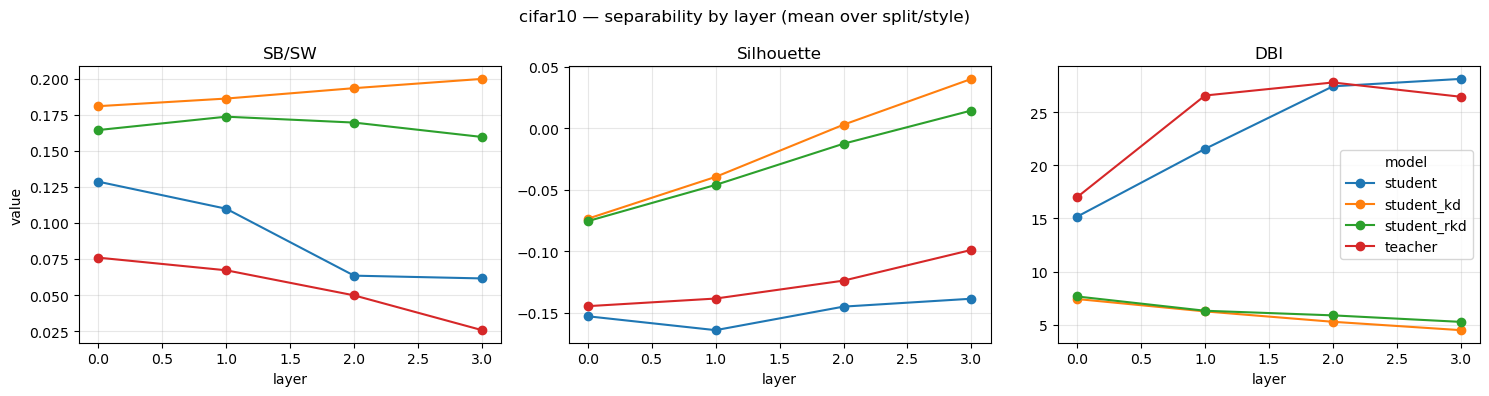

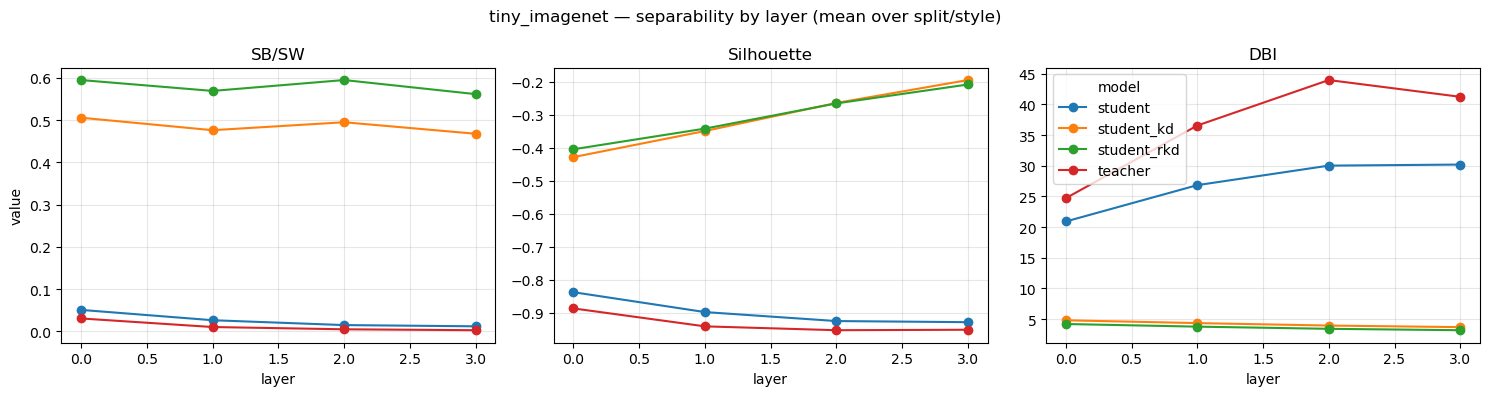

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === (선택) 특정 style만 보고 싶을 때 필터링 예시 ===
# sep_use = sep_df[sep_df["style"] == "at"].copy()
# sep_use = sep_df[sep_df["style"] == "aap"].copy()
sep_use = sep_df[sep_df["style"] == "mhrp"].copy()

# 기본: split/style에 대해 평균 집계하여 사용
# sep_use = sep_df.copy()

datasets = sep_use["dataset"].unique().tolist()
metrics = ["SB/SW", "Silhouette", "DBI"]
models  = ["student", "student_kd", "student_rkd", "teacher"]

for ds in datasets:
    df_ds = sep_use[sep_use["dataset"] == ds].copy()
    
    # 레이어별/모델별 평균 집계 (split, style 평균)
    agg = (df_ds
           .groupby(["model", "layer"], as_index=False)[metrics]
           .mean())

    # 레이어 정렬
    agg = agg.sort_values(["layer", "model"])

    # 그림: 1x3 서브플롯
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
    for ax, metric in zip(axes, metrics):
        for md in models:
            df_md = agg[agg["model"] == md].sort_values("layer")
            if df_md.empty:
                continue
            ax.plot(df_md["layer"].values,
                    df_md[metric].values,
                    marker="o",
                    label=md)
        ax.set_title(metric)
        ax.set_xlabel("layer")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("value")
    axes[-1].legend(title="model", loc="best")
    fig.suptitle(f"{ds} — separability by layer (mean over split/style)")
    fig.tight_layout()
    plt.show()


## 2) AT overlays (image + attention map)

- Rebuild dataset loaders (no augmentation) to fetch images by `sample_id` (=dataset index).
- For a chosen layer, retrieve AT vectors, reshape to `(H,W)` where `H=W=int(sqrt(D))`.
- Upsample to image size and overlay as heatmap for **teacher vs student vs student_kd** on the **same sample**.


In [73]:
# Bring in your repo's loaders + index utilities
from src.data.data_setup import loaders as data_loaders
from src.data.indexed import WithIndex, collate_with_index
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

def build_base_dataset(dataset_key: str, split: str, batch_size: int=64, root: str="dataset",
                       num_workers: int=2, pin_memory: bool=True, download: bool=False):
    train_dict, test_dict = data_loaders(batch_size=batch_size, root=root, num_workers=num_workers, pin_memory=pin_memory, download=download)
    is_train = (split=="train")
    dd = train_dict if is_train else test_dict
    if dataset_key not in dd:
        raise KeyError(f"{dataset_key} not found. Available: {list(dd.keys())}")
    base = dd[dataset_key].dataset
    return base  # raw dataset (with transform)

def fetch_image_by_idx(base_dataset, idx: int, try_unnorm: bool=True):
    x, y = base_dataset[idx]  # may be normalized tensor
    if isinstance(x, torch.Tensor):
        # Try to roughly unnormalize if mean/std are discoverable, else clamp
        img = x.detach().clone()
        # Heuristic unnorm: try attributes
        mean = getattr(base_dataset, 'mean', None) or getattr(getattr(base_dataset, 'transform', None), 'mean', None)
        std  = getattr(base_dataset, 'std', None)  or getattr(getattr(base_dataset, 'transform', None), 'std', None)
        if try_unnorm and mean is not None and std is not None:
            m = torch.as_tensor(mean, dtype=img.dtype, device=img.device).view(-1,1,1)
            s = torch.as_tensor(std, dtype=img.dtype, device=img.device).view(-1,1,1)
            img = img * s + m
        img = img.clamp(0,1)
        pil = to_pil_image(img.cpu())
    else:
        pil = x  # already PIL
    return pil, int(y)

def overlay_heatmap_on_image(pil_img, heatmap_2d: np.ndarray, alpha: float=0.45, cmap="jet"):
    # Normalize heatmap to [0,1], resize to image size
    hm = heatmap_2d.astype(np.float32)
    hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)
    H, W = hm.shape
    import torchvision.transforms.functional as TF
    t = TF.to_tensor(pil_img).unsqueeze(0)
    hm_t = torch.from_numpy(hm)[None,None,:,:]
    hm_up = F.interpolate(hm_t, size=(t.shape[2], t.shape[3]), mode="bilinear", align_corners=False)[0,0].numpy()

    # Matplotlib overlay
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(pil_img)
    ax.imshow(hm_up, cmap=cmap, alpha=alpha)
    ax.axis('off')
    fig.tight_layout()
    return fig

def show_at_overlays(dataset_key: str, split: str, layer_idx: int, sample_ids: List[int], cmap="jet"):
    base = build_base_dataset(dataset_key, split)
    h5p = h5_path_for(dataset_key, split)

    # read AT vectors for all models at this layer
    at_vectors = {}
    dim_check = None
    for md in MODELS:
        X, y, sid = read_features(h5p, md, "at", layer_idx)
        at_vectors[md] = {"X": X, "y": y, "sid": sid}
        if dim_check is None: dim_check = X.shape[1]
        else: assert X.shape[1]==dim_check, "AT dims differ across models; expected equal due to teacher-policy resize."

    # figure out H,W
    D = dim_check
    H = int(round(math.sqrt(D)))
    W = H
    assert H*W == D, f"AT dim {D} is not a perfect square; cannot reshape to (H,W) safely."

    # For each sample_id, render a row with t/s/s_kd
    n = len(sample_ids)
    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(3*3, n*3))
    if n==1:
        axes = np.array([axes])
    for i, sid0 in enumerate(sample_ids):
        pil, y = fetch_image_by_idx(base, sid0)
        # find indices in each model's arrays
        cols = ["teacher","student","student_kd", "student_rkd"]
        for j, md in enumerate(cols):
            arr = at_vectors[md]["X"]
            sids = at_vectors[md]["sid"]
            # locate the row where sample_id == sid0 (if multiple, take first)
            idxs = np.where(sids==sid0)[0]
            if len(idxs)==0:
                axes[i,j].imshow(pil); axes[i,j].set_title(f"{md}: no AT for id={sid0}")
                axes[i,j].axis('off'); continue
            x = arr[idxs[0]]
            hm = x.reshape(H,W)
            # overlay
            axes[i,j].imshow(pil)
            axes[i,j].imshow((hm - hm.min())/(hm.max()-hm.min()+1e-8), cmap=cmap, alpha=0.45)
            axes[i,j].set_title(f"{md} (y={y})")
            axes[i,j].axis('off')
    fig.suptitle(f"AT overlays — {dataset_key}/{split} layer={layer_idx}")
    fig.tight_layout()
    plt.show()


## 3) AT linear probe (classification)
- Train a linear classifier (softmax regression) on **train** split AT features, evaluate on **valid** split.
- Run per dataset, per layer, per model (teacher/student/student_kd).  
- This measures **class separability** in the AT space.

> Note: uses PyTorch for the small linear model (one linear layer).


In [ ]:
class LinearProbe(nn.Module):
    def __init__(self, D: int, C: int):
        super().__init__()
        self.fc = nn.Linear(D, C, bias=True)

    def forward(self, x):
        return self.fc(x)

def train_probe(Xtr, ytr, Xva, yva, num_classes: int, epochs: int=20, lr: float=1e-2, wd: float=1e-4, bs: int=256, device="cpu"):
    Xtr = torch.tensor(Xtr, dtype=torch.float32, device=device)
    ytr = torch.tensor(ytr, dtype=torch.long, device=device)
    Xva = torch.tensor(Xva, dtype=torch.float32, device=device)
    yva = torch.tensor(yva, dtype=torch.long, device=device)

    model = LinearProbe(Xtr.shape[1], num_classes).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    crit = nn.CrossEntropyLoss()

    def run_epoch(X, y, train=True):
        model.train(train)
        N = X.shape[0]
        idx = torch.randperm(N, device=device)
        losses = []
        correct = 0
        for i in range(0, N, bs):
            sel = idx[i:i+bs]
            xb, yb = X[sel], y[sel]
            logits = model(xb)
            loss = crit(logits, yb)
            if train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                opt.step()
            losses.append(loss.item())
            if not train:
                pred = logits.argmax(1)
                correct += (pred==yb).sum().item()
        if train:
            return float(np.mean(losses)/torch.log(torch.tensor(num_classes)))
        else:
            acc = correct / float(N)
            return float(np.mean(losses)/torch.log(torch.tensor(num_classes))), acc

    best_acc = 0.0
    best_NCE = -1
    best = None
    for ep in range(1, epochs+1):
        tr_loss = run_epoch(Xtr, ytr, train=True)
        va_loss, va_acc = run_epoch(Xva, yva, train=False)
        if va_acc > best_acc:
            best_acc = va_acc
            best = {"state": {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}, "acc": va_acc}
        if best_NCE < 0 or va_loss < best_NCE:
            best_NCE = va_loss
        if ep % 5 == 0 or ep==1:
            print(f"ep{ep:02d} tr_loss={tr_loss:.4f} va_loss={va_loss:.4f} va_acc={va_acc:.4f}")
    # restore best
    if best is not None:
        model.load_state_dict(best["state"])
    return best_acc, best_NCE, model

def run_at_linear_probe_for_dataset(dataset_key: str, device="cpu", epochs=20):
    print(f"== Linear probe (AT) for dataset: {dataset_key} ==")
    h5_train = h5_path_for(dataset_key, "train")
    h5_valid = h5_path_for(dataset_key, "valid")
    # infer num_classes from teacher logits dim (fallback to prototypes attr)
    with h5py.File(h5_train, "r") as h5:
        lc = None
        if "/logits/teacher/logits" in h5:
            lc = h5["/logits/teacher/logits"].shape[1]
        if lc is None:
            # try prototypes
            grp = h5.get("/prototypes/teacher/at")
            if grp is not None:
                any_layer = next(iter(grp.keys()))
                lc = int(grp[any_layer].attrs.get("num_classes", 10))
        if lc is None: lc = 10
    num_classes = int(lc)

    results = []
    for md in MODELS:
        layers = list_layers(h5_train, md, "at")
        for li in layers:
            Xtr, ytr, sid_tr = read_features(h5_train, md, "at", li)
            Xva, yva, sid_va = read_features(h5_valid, md, "at", li)
            print(f"[{md}] layer {li}: D={Xtr.shape[1]}")
            acc, loss, _ = train_probe(Xtr, ytr, Xva, yva, num_classes=num_classes, epochs=epochs, device=device)
            results.append({"dataset": dataset_key, "model": md, "layer": li, "acc": acc, "NCE": loss})
    return pd.DataFrame(results).sort_values(["model","layer"])


### Run: Class separability


In [37]:
sep_df

,dataset,split,style,model,layer,SB/SW,Silhouette,DBI,N,D
4,cifar10,train,aap,student,0,0.232017,-0.203457,8.178509,1984,64
8,cifar10,train,aap,student_kd,0,0.216713,-0.055101,6.783537,1984,64
0,cifar10,train,aap,teacher,0,0.134323,-0.178361,8.917477,2112,64
5,cifar10,train,aap,student,1,0.211742,-0.195412,8.071857,1984,64
9,cifar10,train,aap,student_kd,1,0.214704,-0.024206,6.204166,1984,64
...,...,...,...,...,...,...,...,...,...,...
142,tiny_imagenet,valid,mhrp,student_kd,2,0.562244,-0.270651,3.436448,990,128
134,tiny_imagenet,valid,mhrp,teacher,2,0.400947,-0.462772,5.042712,990,128
139,tiny_imagenet,valid,mhrp,student,3,0.389737,-0.487778,5.254882,990,128
143,tiny_imagenet,valid,mhrp,student_kd,3,0.533277,-0.214381,3.212764,990,128


### Run: AT overlays
Example: pick a dataset/split, layer, and a few `sample_id`s present in the H5 file.


Available AT layers: [1, 3, 5, 7]
Chosen sample_ids: [607, 604, 246, 493, 777, 329]


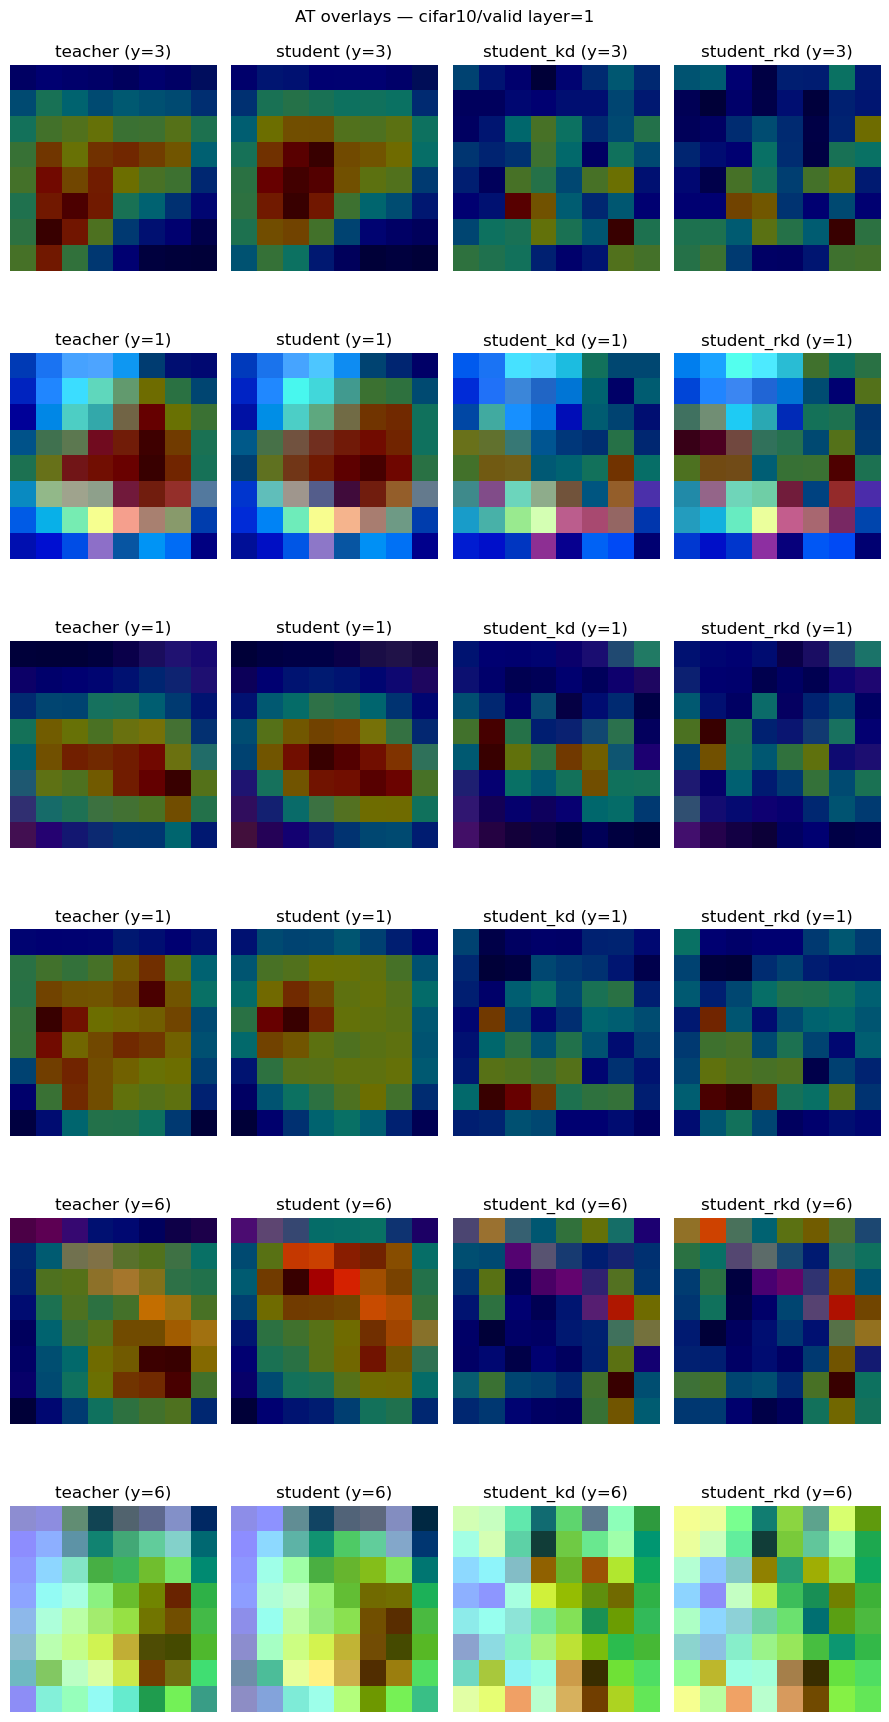

In [74]:
# Example usage (edit these):
DATASET_EX = DATASETS[0] if DATASETS else "cifar10"
SPLIT_EX = "valid"
LAYER_EX = 1   # e.g., one of list_layers(h5_path_for(DATASET_EX, SPLIT_EX), "teacher", "at")
H5_EX = h5_path_for(DATASET_EX, SPLIT_EX)
print("Available AT layers:", list_layers(H5_EX, "teacher", "at"))

# Pick a few sample_ids that exist in all models (intersection)
def common_sample_ids(h5_path: str, layer_idx: int, k: int=6) -> List[int]:
    sets = []
    for md in ["teacher","student","student_kd", "student_rkd"]:
        X, y, sid = read_features(h5_path, md, "at", layer_idx)
        sets.append(set(sid.tolist()))
    inter = list(set.intersection(*sets))
    random.shuffle(inter)
    return inter[:k]

SIDS = common_sample_ids(H5_EX, LAYER_EX, k=6)
print("Chosen sample_ids:", SIDS)

# Show overlays
show_at_overlays(DATASET_EX, SPLIT_EX, LAYER_EX, SIDS)


### Run: AT linear probe (both datasets)


In [50]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
probe_results = []
for ds in DATASETS:
    df = run_at_linear_probe_for_dataset(ds, device=DEVICE, epochs=20)
    probe_results.append(df)
probe_df = pd.concat(probe_results, ignore_index=True) if probe_results else pd.DataFrame()
probe_df


== Linear probe (AT) for dataset: cifar10 ==
[teacher] layer 1: D=64
ep01 tr_loss=1.0198 va_loss=1.0105 va_acc=0.1041
ep05 tr_loss=0.9775 va_loss=0.9850 va_acc=0.1602
ep10 tr_loss=0.9579 va_loss=0.9826 va_acc=0.1461
ep15 tr_loss=0.9434 va_loss=0.9766 va_acc=0.1682
ep20 tr_loss=0.9348 va_loss=0.9738 va_acc=0.1742
[teacher] layer 3: D=16
ep01 tr_loss=1.0194 va_loss=1.0153 va_acc=0.1011
ep05 tr_loss=0.9913 va_loss=0.9981 va_acc=0.1061
ep10 tr_loss=0.9687 va_loss=1.0007 va_acc=0.1281
ep15 tr_loss=0.9609 va_loss=0.9979 va_acc=0.1391
ep20 tr_loss=0.9555 va_loss=0.9956 va_acc=0.1231
[teacher] layer 5: D=16
ep01 tr_loss=1.0168 va_loss=1.0083 va_acc=0.1001
ep05 tr_loss=0.9971 va_loss=1.0000 va_acc=0.1001
ep10 tr_loss=0.9889 va_loss=0.9997 va_acc=0.0941
ep15 tr_loss=0.9732 va_loss=1.0098 va_acc=0.0981
ep20 tr_loss=0.9661 va_loss=1.0085 va_acc=0.0971
[teacher] layer 7: D=4
ep01 tr_loss=1.0190 va_loss=1.0161 va_acc=0.1001
ep05 tr_loss=1.0022 va_loss=1.0013 va_acc=0.1001
ep10 tr_loss=0.9988 va_loss

,dataset,model,layer,acc,NCE
0,cifar10,student,0,0.160160,0.998156
1,cifar10,student,1,0.126126,1.002577
2,cifar10,student,2,0.115115,1.001240
3,cifar10,student,3,0.111111,0.999897
4,cifar10,student_kd,0,0.249249,0.936349
5,cifar10,student_kd,1,0.272272,0.927665
6,cifar10,student_kd,2,0.211211,0.955319
7,cifar10,student_kd,3,0.205205,0.954854
8,cifar10,teacher,1,0.178178,0.970085
9,cifar10,teacher,3,0.145145,0.995504


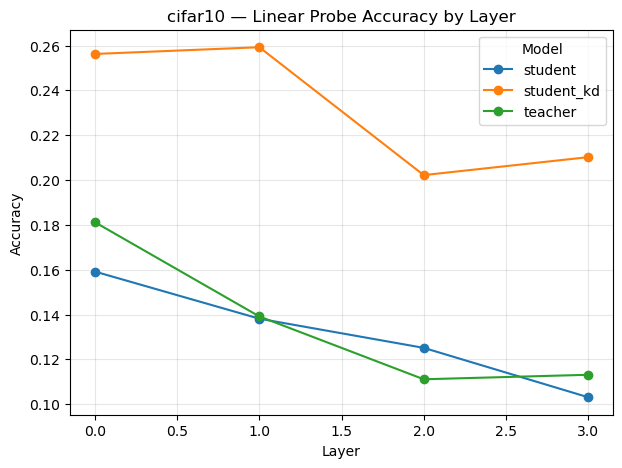

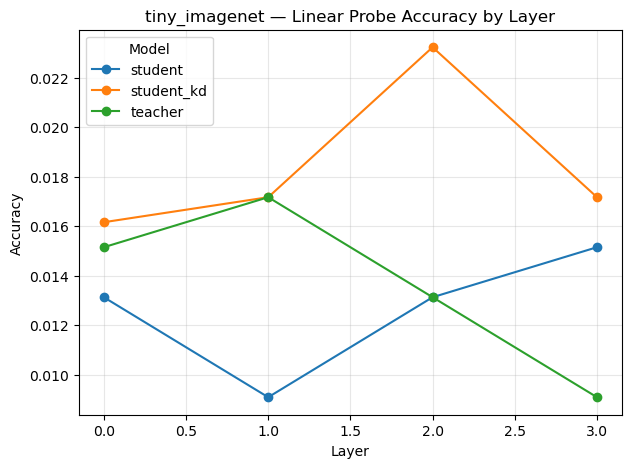

In [34]:
import matplotlib.pyplot as plt

# 데이터프레임 복사 후 teacher layer 조정
plot_df = probe_df.copy()
plot_df.loc[plot_df["model"] == "teacher", "layer"] = (
    (plot_df.loc[plot_df["model"] == "teacher", "layer"] - 1) // 2
)

models = ["student", "student_kd", "teacher"]

for ds in plot_df["dataset"].unique():
    df_ds = plot_df[plot_df["dataset"] == ds].copy()
    
    fig, ax = plt.subplots(figsize=(7,5))
    for md in models:
        df_md = df_ds[df_ds["model"] == md].sort_values("layer")
        if df_md.empty:
            continue
        ax.plot(df_md["layer"], df_md["acc"], marker="o", label=md)
    
    ax.set_title(f"{ds} — Linear Probe Accuracy by Layer")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Accuracy")
    ax.grid(True, alpha=0.3)
    ax.legend(title="Model")
    plt.show()


AT matching experiments:
1) L2 distance statistics between (s, t) and (s_kd, t)
2) Train linear projection (LP) to map AT_s -> AT_t and AT_skd -> AT_t with L2 (MSE) loss

Usage:
    python -m src.analysis.at_match --cfg experiments/analysis/config.yaml --datasets cifar10 tiny_imagenet \
        --layers all --epochs 50 --lr 5e-3 --wd 1e-4 --bs 512 --device cuda

Notes:
- Assumes AT features were collected with teacher-policy resize and L2 normalization at collection time.
- HDF5 schema:
    /features/{model}/at/layer_{i}/(emb|class_id|sample_id)

In [59]:
# === AT alignment: L2 distance (student ↔ teacher, student_kd ↔ teacher) ===
import numpy as np
import pandas as pd
import h5py

def aligned_at_pairs(h5_path: str, layer_idx: int, model_src: str, model_tgt: str="teacher"):
    """
    같은 layer에서 같은 sample_id를 가진 AT 벡터를 페어로 정렬해서 반환.
    return: X_src (N,D), X_tgt (N,D), sids (N,)
    """
    Xs, ys, sid_s = read_features(h5_path, model_src, "at", layer_idx)
    Xt, yt, sid_t = read_features(h5_path, model_tgt, "at", layer_idx)
    # 교집합 정렬
    common = np.intersect1d(sid_s, sid_t, assume_unique=False)
    if len(common) == 0:
        raise RuntimeError(f"No common sample_ids between {model_src} and {model_tgt} at layer={layer_idx}")
    # 인덱스 매핑
    idx_s = np.nonzero(np.isin(sid_s, common))[0]
    idx_t = np.nonzero(np.isin(sid_t, common))[0]
    # 동일 순서로 맞추기
    order = np.argsort(sid_s[idx_s])
    idx_s = idx_s[order]
    sid_sorted = sid_s[idx_s]
    map_t = {v:i for i,v in enumerate(sid_t[idx_t])}
    idx_t_aligned = np.array([map_t[v] for v in sid_sorted], dtype=int)
    Xsrc = Xs[idx_s]
    Xtgt = Xt[idx_t_aligned]
    assert Xsrc.shape[1] == Xtgt.shape[1], "AT dims must match (teacher policy resize during collection)."
    return Xsrc.astype(np.float32), Xtgt.astype(np.float32), sid_sorted

def l2_mean(a, b):
    return float(np.mean(np.linalg.norm(a - b, axis=1)))

def at_l2_report(dataset_key: str, split: str="valid"):
    h5p = h5_path_for(dataset_key, split)
    rows = []
    for li in list_layers(h5p, "teacher", "at"):
        for src in ["student", "student_kd"]:
            try:
                Xs, Xt, sids = aligned_at_pairs(h5p, li, src, "teacher")
                l2m = l2_mean(Xs, Xt)
                rows.append({"dataset": dataset_key, "split": split, "layer": li, "pair": f"{src}↔teacher", "L2_mean": l2m, "N": len(sids), "D": Xs.shape[1]})
            except Exception as e:
                print(f"[skip] {dataset_key}/{split} L{li} {src}: {e}")
    return pd.DataFrame(rows).sort_values(["layer","pair"])

# 예시 실행
reports = []
for ds in DATASETS:
    reports.append(at_l2_report(dataset_key=ds, split="valid"))
at_l2_df = pd.concat(reports, ignore_index=True) if reports else pd.DataFrame()
at_l2_df


[skip] cifar10/valid L5 student: 'No features at /features/student/at/layer_5'
[skip] cifar10/valid L5 student_kd: 'No features at /features/student_kd/at/layer_5'
[skip] cifar10/valid L7 student: 'No features at /features/student/at/layer_7'
[skip] cifar10/valid L7 student_kd: 'No features at /features/student_kd/at/layer_7'
[skip] tiny_imagenet/valid L5 student: 'No features at /features/student/at/layer_5'
[skip] tiny_imagenet/valid L5 student_kd: 'No features at /features/student_kd/at/layer_5'
[skip] tiny_imagenet/valid L7 student: 'No features at /features/student/at/layer_7'
[skip] tiny_imagenet/valid L7 student_kd: 'No features at /features/student_kd/at/layer_7'


,dataset,split,layer,pair,L2_mean,N,D
0,cifar10,valid,1,student_kd↔teacher,0.415326,1998,64
1,cifar10,valid,1,student↔teacher,0.177472,1998,64
2,cifar10,valid,3,student_kd↔teacher,0.445224,1998,16
3,cifar10,valid,3,student↔teacher,0.172529,1998,16
4,tiny_imagenet,valid,1,student_kd↔teacher,0.449727,990,256
5,tiny_imagenet,valid,1,student↔teacher,0.229317,990,256
6,tiny_imagenet,valid,3,student_kd↔teacher,0.528932,990,64
7,tiny_imagenet,valid,3,student↔teacher,0.197899,990,64


In [60]:
# === AT matching: learn a linear mapper (L2 regression) from student AT → teacher AT ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class LinearATMatcher(nn.Module):
    """
    y ≈ x W^T + b  (in_features=D_in, out_features=D_out)
    기본은 D_in==D_out (teacher policy resize). bias=True 권장.
    """
    def __init__(self, D_in: int, D_out: int, bias: bool=True):
        super().__init__()
        self.fc = nn.Linear(D_in, D_out, bias=bias)
        # Xavier init
        nn.init.xavier_uniform_(self.fc.weight)
        if bias: nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        return self.fc(x)

@torch.no_grad()
def eval_l2(model, X, Y, batch_size=2048, device="cpu", renorm=False):
    model.eval()
    X = torch.tensor(X, dtype=torch.float32, device=device)
    Y = torch.tensor(Y, dtype=torch.float32, device=device)
    N = X.shape[0]
    acc_loss = 0.0
    count = 0
    for i in range(0, N, batch_size):
        xb = X[i:i+batch_size]
        yb = Y[i:i+batch_size]
        pred = model(xb)
        if renorm:
            pred = F.normalize(pred, p=2, dim=1)
            yb   = F.normalize(yb,   p=2, dim=1)
        loss = F.mse_loss(pred, yb, reduction="sum").item()
        acc_loss += loss
        count += xb.size(0)
    mse = acc_loss / max(count,1)
    l2_mean = float(np.mean(np.linalg.norm(
        (model(X).detach().cpu().numpy() if not renorm else F.normalize(model(X),p=2,dim=1).cpu().numpy())
        - (Y if not renorm else F.normalize(torch.tensor(Y),p=2,dim=1)).cpu().numpy()
    , axis=1)))
    return mse, l2_mean

def train_at_matcher(Xtr, Ytr, Xva, Yva, epochs=100, lr=3e-3, wd=1e-4, bs=1024, device=None, renorm=False, verbose=True):
    """
    Xtr: student AT,  Ytr: teacher AT (same D ideally)
    loss: MSE (optionally after L2 renorm)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    Xtr = torch.tensor(Xtr, dtype=torch.float32, device=device)
    Ytr = torch.tensor(Ytr, dtype=torch.float32, device=device)
    Xva = torch.tensor(Xva, dtype=torch.float32, device=device)
    Yva = torch.tensor(Yva, dtype=torch.float32, device=device)

    D_in, D_out = Xtr.shape[1], Ytr.shape[1]
    model = LinearATMatcher(D_in, D_out, bias=True).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    def one_epoch(train=True):
        if train: model.train()
        else:     model.eval()
        N = Xtr.shape[0] if train else Xva.shape[0]
        idx = torch.randperm(N, device=device)
        losses = []
        for i in range(0, N, bs):
            sel = idx[i:i+bs]
            xb = (Xtr if train else Xva)[sel]
            yb = (Ytr if train else Yva)[sel]
            pred = model(xb)
            if renorm:
                pred = F.normalize(pred, p=2, dim=1)
                yb   = F.normalize(yb,   p=2, dim=1)
            loss = F.mse_loss(pred, yb, reduction="mean")
            if train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                opt.step()
            losses.append(loss.item())
        return float(np.mean(losses))

    best = {"state": None, "val_loss": np.inf}
    for ep in range(1, epochs+1):
        tr = one_epoch(train=True)
        va = one_epoch(train=False)
        if va < best["val_loss"]:
            best["val_loss"] = va
            best["state"] = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        if verbose and (ep % max(epochs//5,1) == 0 or ep==1):
            print(f"[AT-Match] ep{ep:03d}  tr={tr:.6f}  va={va:.6f}")

    if best["state"] is not None:
        model.load_state_dict(best["state"])
    # 최종 지표
    va_mse, va_l2 = eval_l2(model, Xva.cpu().numpy(), Yva.cpu().numpy(), device=device, renorm=renorm)
    return model, {"val_mse": va_mse, "val_l2": va_l2}


In [ ]:
# === Run: for each dataset & layer, train linear AT matcher (s→t, skd→t) and report L2 before/after ===
import math

def run_at_matching_experiments(DATASETS, split_train="train", split_valid="valid",
                                epochs=100, lr=3e-3, wd=1e-4, bs=1024,
                                renorm=True, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    rows = []
    for ds in DATASETS:
        h5_tr = h5_path_for(ds, split_train)
        h5_va = h5_path_for(ds, split_valid)
        layers = list_layers(h5_va, "teacher", "at")
        print(f"\n== {ds}: layers {layers} ==")
        for li in layers:
            for src in ["student", "student_kd"]:
                # Train/Valid aligned pairs
                try:
                    Xtr_s, Ytr_t, sids_tr = aligned_at_pairs(h5_tr, li, src, "teacher")
                    Xva_s, Yva_t, sids_va = aligned_at_pairs(h5_va, li, src, "teacher")
                except Exception as e:
                    print(f"[skip] {ds} L{li} {src}: {e}")
                    continue

                # 사전 L2 (학습 전)
                pre_l2_tr = l2_mean(Xtr_s, Ytr_t)
                pre_l2_va = l2_mean(Xva_s, Yva_t)

                # 학습
                print(f"[{ds}] L{li} {src}→teacher  (train N={len(sids_tr)}, valid N={len(sids_va)}, D={Xtr_s.shape[1]})")
                model, metr = train_at_matcher(Xtr_s, Ytr_t, Xva_s, Yva_t,
                                               epochs=epochs, lr=lr, wd=wd, bs=bs,
                                               device=device, renorm=renorm, verbose=True)

                # 사후 L2 (학습 후, valid)
                with torch.no_grad():
                    Xva_t = torch.tensor(Xva_s, dtype=torch.float32, device=device)
                    pred  = model(Xva_t)
                    pred  = F.normalize(pred, p=2, dim=1) if renorm else pred
                    Yva   = torch.tensor(Yva_t, dtype=torch.float32, device=device)
                    Yva   = F.normalize(Yva, p=2, dim=1) if renorm else Yva
                    post_l2_va = float(torch.norm(pred - Yva, dim=1).mean().item())

                rows.append({
                    "dataset": ds,
                    "layer": li,
                    "source": src,
                    "pre_L2_train": pre_l2_tr,
                    "pre_L2_valid": pre_l2_va,
                    "post_L2_valid": post_l2_va,
                    "val_MSE": metr["val_mse"],
                    "val_L2_mean": metr["val_l2"],
                    "renorm": renorm,
                    "epochs": epochs,
                    "lr": lr, "wd": wd, "bs": bs,
                    "N_train": len(sids_tr), "N_valid": len(sids_va),
                    "D": Xtr_s.shape[1],
                })
    return pd.DataFrame(rows).sort_values(["dataset","layer","source"])

# 실행 예시
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
match_df = run_at_matching_experiments(DATASETS, epochs=100, lr=3e-3, wd=1e-4, bs=1024, renorm=True, device=DEVICE)
match_df



== cifar10: layers [1, 3, 5, 7] ==
[cifar10] L1 student→teacher  (train N=1984, valid N=1998, D=64)
[AT-Match] ep001  tr=0.029378  va=0.022179
[AT-Match] ep020  tr=0.001821  va=0.001930
[AT-Match] ep040  tr=0.001486  va=0.001618
[AT-Match] ep060  tr=0.001276  va=0.001397
[AT-Match] ep080  tr=0.001116  va=0.001226
[AT-Match] ep100  tr=0.000996  va=0.001093
[cifar10] L1 student_kd→teacher  (train N=1984, valid N=1998, D=64)
[AT-Match] ep001  tr=0.034544  va=0.026278


C:\Users\gauoo\AppData\Local\Temp\ipykernel_37060\3899864162.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - (Y if not renorm else F.normalize(torch.tensor(Y),p=2,dim=1)).cpu().numpy()


[AT-Match] ep020  tr=0.001787  va=0.001980
[AT-Match] ep040  tr=0.001694  va=0.001880
[AT-Match] ep060  tr=0.001676  va=0.001864
[AT-Match] ep080  tr=0.001659  va=0.001847
[AT-Match] ep100  tr=0.001639  va=0.001830
[cifar10] L3 student→teacher  (train N=1984, valid N=1998, D=16)
[AT-Match] ep001  tr=0.160337  va=0.165293
[AT-Match] ep020  tr=0.016976  va=0.021468
[AT-Match] ep040  tr=0.005046  va=0.006443
[AT-Match] ep060  tr=0.004377  va=0.005136
[AT-Match] ep080  tr=0.004161  va=0.004957
[AT-Match] ep100  tr=0.003956  va=0.004759
[cifar10] L3 student_kd→teacher  (train N=1984, valid N=1998, D=16)
[AT-Match] ep001  tr=0.109749  va=0.107733
[AT-Match] ep020  tr=0.013580  va=0.015911
[AT-Match] ep040  tr=0.006655  va=0.007748
[AT-Match] ep060  tr=0.005851  va=0.006544
[AT-Match] ep080  tr=0.005542  va=0.006174
[AT-Match] ep100  tr=0.005314  va=0.005942
[skip] cifar10 L5 student: 'No features at /features/student/at/layer_5'
[skip] cifar10 L5 student_kd: 'No features at /features/student

,dataset,layer,source,pre_L2_train,pre_L2_valid,post_L2_valid,val_MSE,val_L2_mean,renorm,epochs,lr,wd,bs,N_train,N_valid,D
0,cifar10,1,student,0.238173,0.177472,0.256158,0.069955,0.256158,True,100,0.003,0.0001,1024,1984,1998,64
1,cifar10,1,student_kd,0.432526,0.415326,0.327435,0.117081,0.327435,True,100,0.003,0.0001,1024,1984,1998,64
2,cifar10,3,student,0.202993,0.172529,0.265863,0.076146,0.265863,True,100,0.003,0.0001,1024,1984,1998,16
3,cifar10,3,student_kd,0.446582,0.445224,0.298625,0.095103,0.298625,True,100,0.003,0.0001,1024,1984,1998,16
4,tiny_imagenet,1,student,0.282771,0.229317,0.365696,0.141756,0.365696,True,100,0.003,0.0001,1024,998,990,256
5,tiny_imagenet,1,student_kd,0.430193,0.449727,0.409599,0.179679,0.409599,True,100,0.003,0.0001,1024,998,990,256
6,tiny_imagenet,3,student,0.190267,0.197899,0.307879,0.103206,0.307879,True,100,0.003,0.0001,1024,998,990,64
7,tiny_imagenet,3,student_kd,0.541647,0.528932,0.338598,0.124137,0.338598,True,100,0.003,0.0001,1024,998,990,64
